In [3]:
import pandas
import numpy
import matplotlib.pyplot as plt
import specplotlib
from tqdm import tqdm_notebook as tqdm

# Data Table

In [4]:
# Load Data
X_SG = numpy.load('X_SG.npy')
CW = numpy.load('CW.npy')
sn_spec_time = numpy.load('sn_spec_time.npy')
nof_objects = X_SG.shape[0]
SN_df_w_salt_w_class = pandas.read_csv('good_df.csv')
SN_df_w_salt_w_class.head()

,idx,SN,zhel_spec,tmax(B)_spec,tmax(B)_err_spec,ref_spec,Dm15_spec,Dm15_err_spec,ref1_spec,M_B_spec,...,z_cmb_salt,z_err_salt,m_B_salt,m_B_err_salt,s_salt,s_err_salt,c_salt,c_err_salt,mu_salt,mu_err_salt
0,0,1994D,0.0029,49432.5,0.1,"B,M,SA,SN",1.37,0.03,B,-99.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1994M,0.0232,49474.5,0.9,"B,M,SA,SN",1.26,0.06,B,-19.21,...,0.024,0.001,16.30,0.159,0.78,0.02,0.11,0.02,35.207,0.205
2,2,1994S,0.0151,49518.3,0.3,"B,M,SA,SN",0.94,0.06,B,-19.55,...,0.015,0.001,14.77,0.196,1.09,0.05,-0.01,0.02,34.372,0.280
3,3,1994T,0.0346,49514.4,0.4,"M,SN",1.51,0.08,SN,-99.99,...,0.036,0.001,17.05,0.084,0.84,0.04,0.02,0.05,36.264,0.181
4,4,1994ae,0.0043,49685.5,0.8,"B,M,SA,SN",0.96,0.04,B,-99.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Normlize the spectra
def get_norm_X(X):
    nof_object = X.shape[0]
    for i in range(nof_objects):
        X[i] = X[i]/numpy.median(X[i])
    return X

In [6]:
SN_df_w_salt_w_class.columns

Index(['idx', 'SN', 'zhel_spec', 'tmax(B)_spec', 'tmax(B)_err_spec',
       'ref_spec', 'Dm15_spec', 'Dm15_err_spec', 'ref1_spec', 'M_B_spec',
       'M_B_err_spec', 'B-V_spec', 'B-V_err_spec', 'Bm-Vm_spec',
       'Bm-Vm_err_spec', 'Phot_ref_spec', 'ref..2', 'n_spec', 'RA', 'DEC',
       'z_CMB', 'z_CMB_salt2_err', 'm_B_salt2', 'm_B_salt2_err', 'x_1_salt2',
       'x_1_salt2_err', 'c_salt2', 'c_salt2_err', 'mu_salt2', 'mu_salt2_err',
       'EW5972_spec', 'EW6355_spec', 'v6355_spec', 'Phase_spec', 'BClass_spec',
       'WClass_spec', 'SNIa_salt', 'z_cmb_salt', 'z_err_salt', 'm_B_salt',
       'm_B_err_salt', 's_salt', 's_err_salt', 'c_salt', 'c_err_salt',
       'mu_salt', 'mu_err_salt'],
      dtype='object')

# Finding alpha and beta

In [14]:
SN_df_w_salt_w_class['SN']

0       1994D
1       1994M
2       1994S
3       1994T
4      1994ae
5       1995D
6       1995E
7      1995ac
8      1995al
9       1996C
10      1996X
11      1996Z
12     1996ab
13     1996ai
14     1996bk
15     1996bl
16     1996bo
17      1997E
18      1997Y
19     1997bp
20     1997bq
21     1997br
22     1997do
23     1997dt
24      1998V
25     1998ab
26     1998aq
27     1998bp
28     1998bu
29     1998co
        ...  
199    2007au
200    2007ax
201    2007ba
202    2007bc
203    2007bd
204    2007bm
205    2007ca
206    2007cg
207    2007ci
208    2007co
209    2007cq
210    2007fb
211    2007fs
212    2007hj
213    2007if
214    2007jg
215    2007kk
216    2007le
217    2007nq
218    2007ux
219     2008A
220     2008C
221     2008L
222     2008Q
223     2008R
224     2008Z
225    2008ae
226    2008af
227    2008ar
228    2008bf
Name: SN, Length: 229, dtype: object

In [7]:
# the different distance moduli we have and comparing them
from astropy.cosmology import WMAP9 as cosmo

z_CMB_distmod = cosmo.distmod(SN_df_w_salt_w_class['z_cmb_salt'].values)
z_hel_distmod = cosmo.distmod(SN_df_w_salt_w_class['zhel_spec'].values)

mu = SN_df_w_salt_w_class['mu_salt'].values
#plt.figure(figsize=(15,7))
#plt.scatter(SN_df_w_salt_w_class['z_cmb_salt'].values, mu)
#plt.scatter(z_CMB_distmod, z_CMB_distmod)
#plt.show()

In [8]:
# functions to find alpha and betha
from scipy import optimize

# chi of distance modulus from cosmolgy vs. fit

def model(m0, a, b, x):
    return(-m0 + (x[:,0]-1)*a - x[:,1]*b)

def func(z, *p):
    m0, a, b = z # m0 is absolute M
    x, dx, y, dy = p
    chi2 = ((model(m0, a, b, x)) - y)**2 
    chi2 = chi2/((dx[:,0]*a)**2 + (dx[:,1]*b)**2 + dy**2)
    return numpy.sum(chi2)


# do the fit for m0,a,b (in this order) according to ranges of slice
def lin_fit(x, dx, y, dy):
    p = (x, dx, y, dy)
    rranges = (slice(-20., -19., 0.05), slice(0.5, 2.5, 0.05), slice(1.5, 3.5, 0.05))
    resbrute = optimize.brute(func, rranges, args=p, full_output=True, finish=optimize.fmin)
    
    return resbrute[0]

def plot_groups(gs, X, dX, Y, dY):
    
    plt.figure(figsize=(15,12))
    y_plt = Y.copy()
    dy_plt = dY.copy()

    plt.subplot(211)
    x_plt = X[:,0].copy()
    dx_plt = dX[:,0].copy()
    plt.errorbar(x=x_plt, y=y_plt, yerr=dy_plt, xerr=dx_plt, c='gray', alpha = 0.5,  fmt='o')
    for g in gs:
        plt.errorbar(x=x_plt[g], y=y_plt[g], yerr=dy_plt[g], xerr=dx_plt[g],  fmt='o')
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.xlabel(r'$s_salt$', fontsize = 20)
    plt.ylabel(r'$m_B intrinsic$', fontsize = 20)

    plt.subplot(212)
    x_plt = X[:,1].copy()
    dx_plt = dX[:,1].copy()
    plt.errorbar(x=x_plt, y=y_plt, yerr=dy_plt, xerr=dx_plt, c='gray', alpha = 0.5,  fmt='o')
    for g in gs:
        plt.errorbar(x=x_plt[g], y=y_plt[g], yerr=dy_plt[g], xerr=dx_plt[g],  fmt='o')
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.xlabel(r'$c_salt$', fontsize = 20)
    plt.ylabel(r'$m_B intrinsic$', fontsize = 20)
    
    plt.tight_layout()
    plt.show()
    
    return
    

def group_fit(g, X, dX, Y, dY, flag_plot = True, flag_color = 'default'):
    
    x_ = X[g].copy()
    dx_ = dX[g].copy()
    y_ = Y[g].copy()
    dy_ = dY[g].copy()
    res = lin_fit(x_, dx_, y_, dy_)
    
    if flag_plot:
        
        plt.figure(figsize=(15,12))
        y_plt = Y.copy()
        dy_plt = dY.copy()
        
        plt.subplot(211)
        x_plt = X[:,0].copy()
        dx_plt = dX[:,0].copy()
        plt.errorbar(x=x_plt, y=y_plt, yerr=dy_plt, xerr=dx_plt, c='gray', alpha = 0.5,  fmt='o')
        if flag_color != 'default' :
            plt.errorbar(x=x_plt[g], y=y_plt[g], yerr=dy_plt[g], xerr=dx_plt[g],  fmt='o', c = flag_color)
        
        plt.subplot(212)
        x_plt = X[:,1].copy()
        dx_plt = dX[:,1].copy()
        plt.errorbar(x=x_plt, y=y_plt, yerr=dy_plt, xerr=dx_plt, c='gray', alpha = 0.5,  fmt='o')
        if flag_color != 'default' :
            plt.errorbar(x=x_plt[g], y=y_plt[g], yerr=dy_plt[g], xerr=dx_plt[g],  fmt='o', c = flag_color)
        plt.show()
        
    
    return res


<font color=red>
## !!!!!!!! need to fix the y error from mu_err_salt to the z_cmb_dist from cosmolgy error

In [11]:
# fitting the linear fit for the shoocen groups
has_m_b = numpy.where((numpy.isfinite(SN_df_w_salt_w_class['s_salt'].values)))[0]

Y = z_CMB_distmod.value - SN_df_w_salt_w_class['m_B_salt'].values.copy()
X = numpy.vstack([SN_df_w_salt_w_class['s_salt'].values, SN_df_w_salt_w_class['c_salt'].values]).T

dY = numpy.sqrt(SN_df_w_salt_w_class['mu_err_salt'].values.copy()**2 + SN_df_w_salt_w_class['m_B_err_salt'].values.copy()**2)
dX = numpy.vstack([SN_df_w_salt_w_class['s_err_salt'].values, SN_df_w_salt_w_class['c_err_salt'].values]).T

Yf = Y[has_m_b].copy()
Xf = X[has_m_b].copy()
dYf = dY[has_m_b].copy()
dXf = dX[has_m_b].copy()

from sklearn.metrics.pairwise import euclidean_distances
d_umap = euclidean_distances(s_umap, s_umap)

alpha = numpy.ones(nof_objects)*numpy.nan
beta = numpy.ones(nof_objects)*numpy.nan
m0 = numpy.ones(nof_objects)*numpy.nan

nnn = 8
has_m_b_dmat = d_umap[has_m_b,:][:,has_m_b].copy()
has_m_b_dmat_asort = numpy.argsort(has_m_b_dmat, axis = 1)[:,:nnn]

for i in tqdm(range(len(has_m_b))): #the use in tqdm is in order to plot the timing bar
    g                 = has_m_b_dmat_asort[i]
    inter, a, b       = group_fit(g, Xf, dXf, Yf, dYf, flag_plot=False)
    alpha[has_m_b[i]] = a
    beta[has_m_b[i]]  = b
    m0[has_m_b[i]]    = inter


/Users/natalie/anaconda2/envs/fun/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


# All wl

In [10]:
# load map 
s_umap = numpy.load('umap_frf.npy')
x=s_umap[:,0]
y=s_umap[:,1]

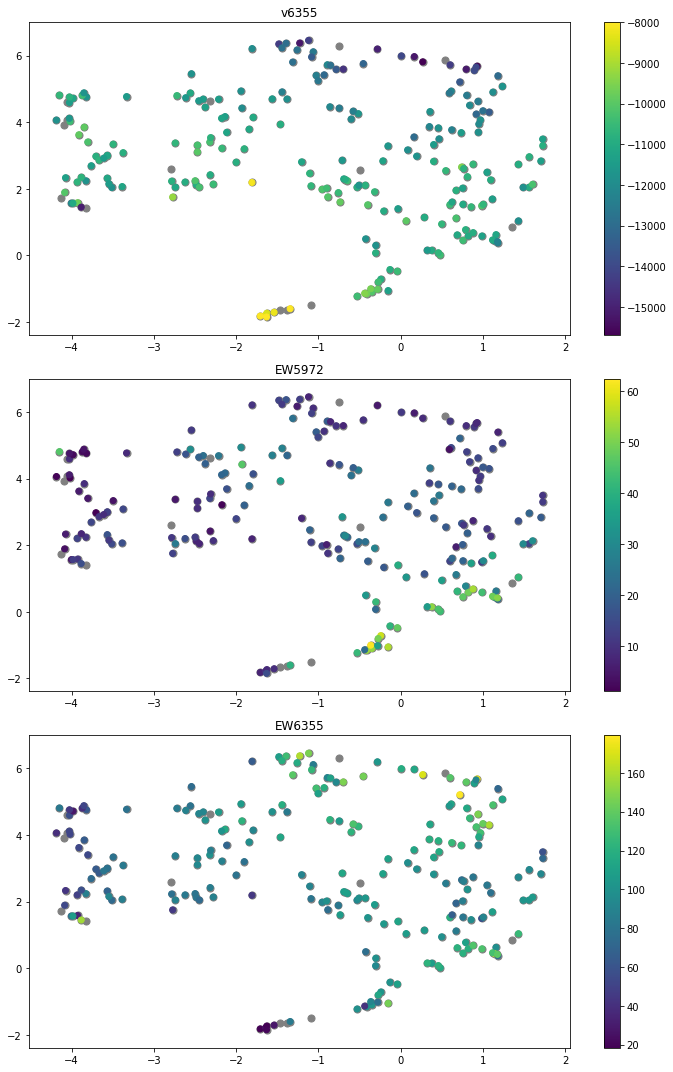

In [7]:
specplotlib.embedding_plot_spec_meas(s_umap, SN_df_w_salt_w_class)

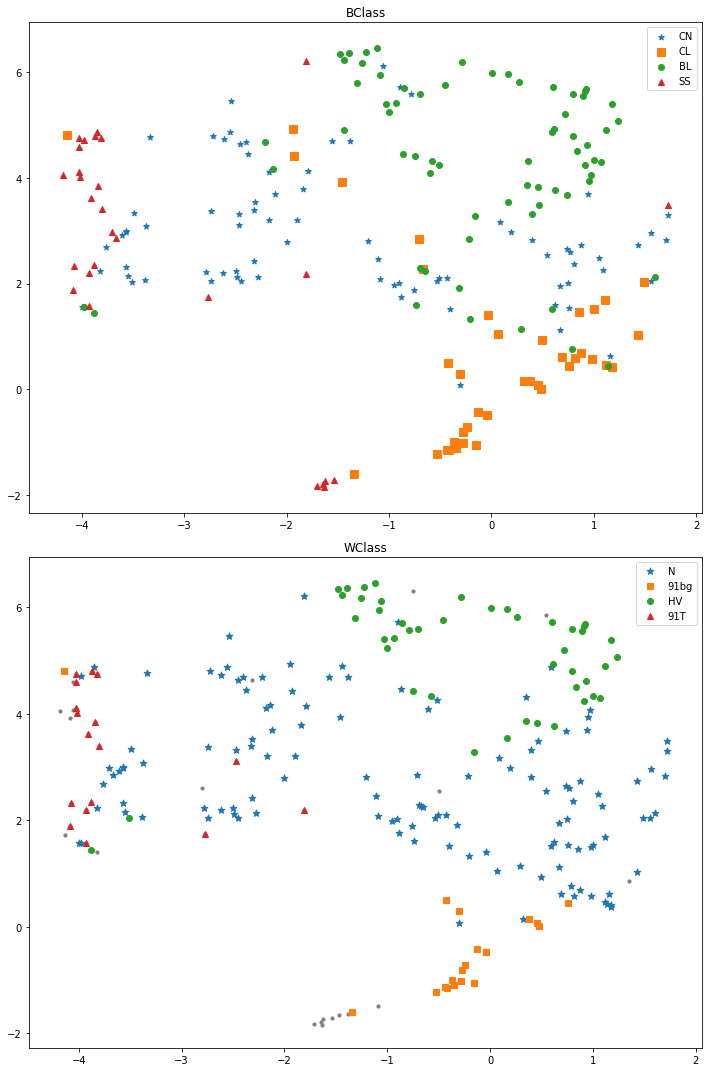

In [8]:
specplotlib.embedding_plot_groups(s_umap, SN_df_w_salt_w_class)

/Users/natalie/git/SNIa/specplotlib.py:278: RuntimeWarning: invalid value encountered in less
  t[t < cut] = numpy.nan


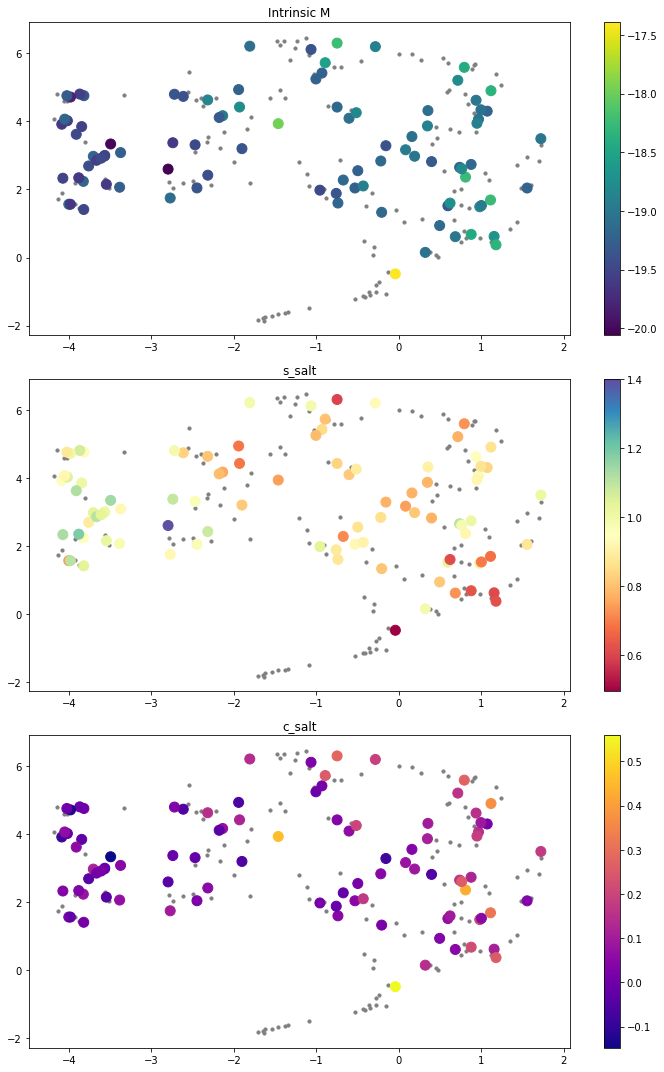

In [9]:
specplotlib.embedding_plot_salt_lc_params(s_umap, SN_df_w_salt_w_class, s=100)
# M is calculated 

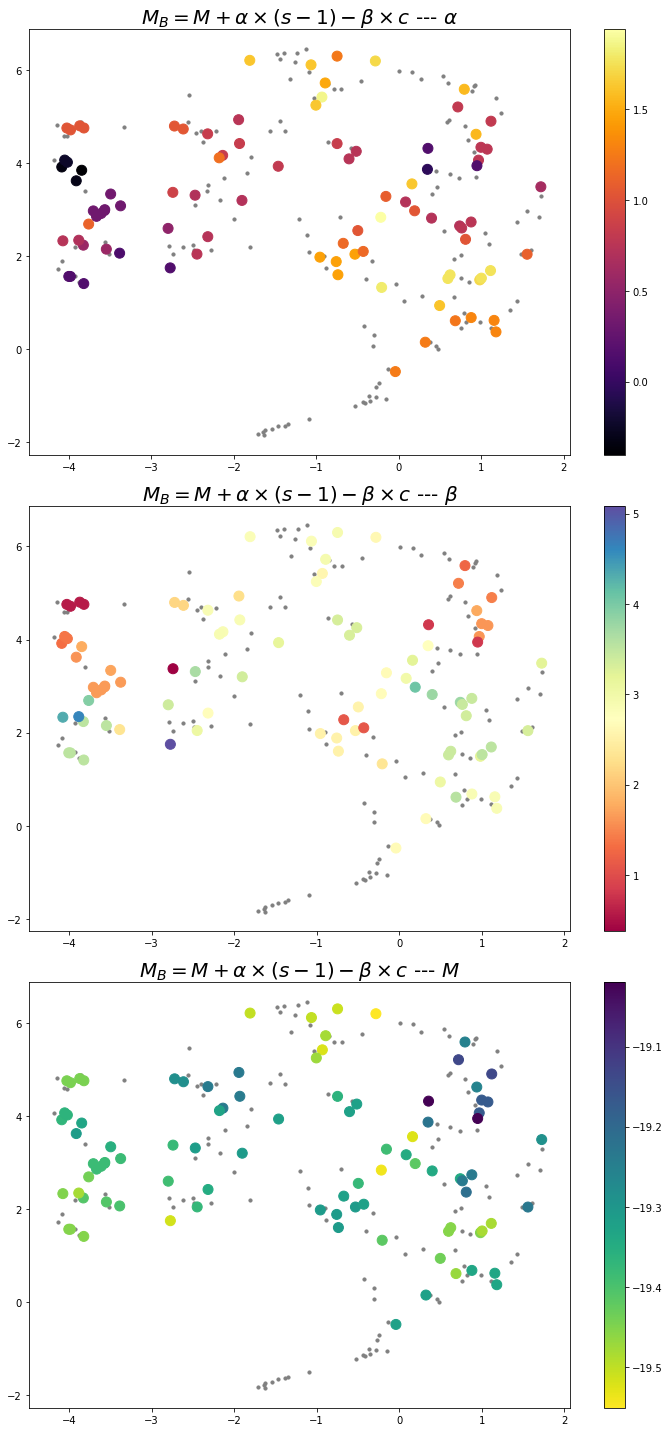

In [23]:
specplotlib.embedding_plot_salt_fit_params(s_umap, alpha, beta, m0, s = 50)

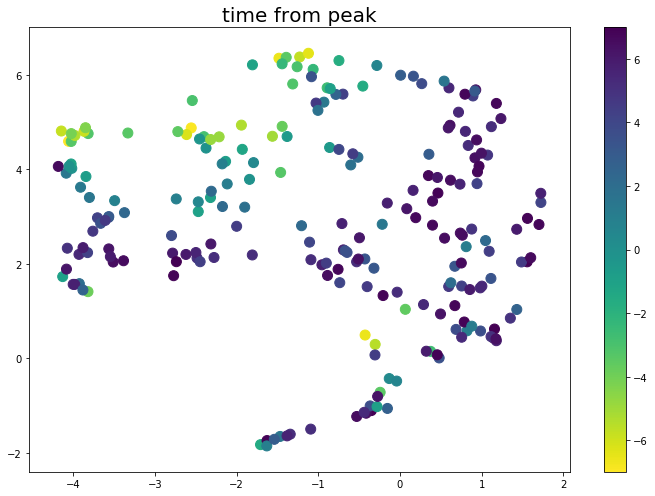

In [59]:
specplotlib.embedding_plot_time_params(s_umap,  m0, s = 50)

# Choosing groups

In [64]:
import load_data
import preprocess_spectra§
import pandas
from importlib import reload
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
cmap = get_cmap('viridis')
import numpy
import specplotlib
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [88]:
# function for displaying group

def plot_group (group_list, gap, line_list, name_list, t):

    fig = plt.figure(figsize = (9,10))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    group_t = numpy.array([numpy.mean(t[g]) for g in group_list]) #creating the list in 1 line 
    plt_indx = numpy.argsort(group_t) # the indx of the group_t list according to order
    nof_groups = len(group_list)
    
    fig.add_subplot(2, 1, 1)
    for i,n in enumerate(plt_indx): # i is the step in the loop and n is place in the list of t (second index goes with ennumrate)
        c = i/(nof_groups-1)
        #plt.plot(cw, numpy.median(X_SG[group_list[n]], axis = 0), label='%.2f' % group_t[n], color=cmap(c)) #blue
        y_plt = numpy.median(X_SG[group_list[n]], axis = 0)
        plt.plot(CW, y_plt+i*gap, label='%.2f' % group_t[n], color=cmap(c))
        
    ax = plt.gca() # holds all the data of the image
    ylim = ax.get_ylim() # keeps the ylim for the upper and border limits of the line
    plt.vlines(x=[line_list], ymin=ylim[0], ymax=ylim[1])
    for n in range (0,len(line_list)):
        plt.text(x=(line_list[n]+4), y=ylim[1]-0.2, s=name_list[n], rotation=90)
    plt.ylim(ylim)
    plt.ylim(ylim)
    #plt.xlim([3500,4000])
    plt.legend()

    fig.add_subplot(2, 1, 2)
    for i,n in enumerate(plt_indx):
        c = i/(nof_groups-1)
        plt.plot(CW, numpy.median(X_SG[group_list[n]], axis = 0), label='%.2f' % group_t[n], color=cmap(c)) #blue
 
    ax = plt.gca() # holds all the data of the image
    ylim = ax.get_ylim() # keeps the ylim for the upper and border limits of the line
    plt.vlines(x=[line_list], ymin=ylim[0], ymax=ylim[1])
    for n in range (0,len(line_list)):
        plt.text(x=(line_list[n]+4), y=ylim[1]-0.2, s=name_list[n], rotation=90)
    plt.ylim(ylim)
    plt.xlim([(min(line_list)-300),(max(line_list)+300)])
    plt.legend()

    plt.show()
    
    print(group_t)
    
    return 

In [61]:
# functions for selecting from Umap
from matplotlib.widgets import RectangleSelector
def get_inds_click(tmap, xmn, xmx, ymn, ymx):
    objnum = tmap.shape[0]
    inds = (tmap[:,0] > xmn) & (tmap[:,0] < xmx) & (tmap[:,1] > ymn) & (tmap[:,1] < ymx)
    inds = numpy.arange(objnum)[inds]
    #tmp_inds = np.argsort(ws[inds])[::-1]
    #inds = inds[tmp_inds]
    return inds


def line_select_callback(eclick, erelease):
    'eclick and erelease are the press and release events'
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    print("(%3.2f, %3.2f) --> (%3.2f, %3.2f)" % (x1, y1, x2, y2))
    print(" The button you used were: %s %s" % (eclick.button, erelease.button))
    global click_inds
    click_inds = get_inds_click(click_map, min(x1,x2), max(x1,x2), min(y1,y2), max(y1,y2))
      
    art = plt.scatter(click_map[click_inds,0], click_map[click_inds,1], s = 100, edgecolors='red', c='none')


def toggle_selector(event):
    print(' Key pressed.')
    if event.key in ['Q', 'q'] and toggle_selector.RS.active:
        print(' RectangleSelector deactivated.')
        toggle_selector.RS.set_active(False)
    if event.key in ['A', 'a'] and not toggle_selector.RS.active:
        print(' RectangleSelector activated.')
        toggle_selector.RS.set_active(True)
        

In [ ]:
# groups by classification
grpN=numpy.where(SN_df_w_salt_w_class["WClass_spec"]=="N")[0]
grpHV=numpy.where(SN_df_w_salt_w_class["WClass_spec"]=="HV")[0]
grp91bg=numpy.where(SN_df_w_salt_w_class["WClass_spec"]=="91bg")[0]
grp91T=numpy.where(SN_df_w_salt_w_class["WClass_spec"]=="91T")[0]

In [501]:
# choose the parameter to color by

# t - the coloring parameter of the dots
t = numpy.load('sn_spec_time.npy')

# a - the width free parameter
a = alpha.copy()
a=numpy.array(a)

# a - the color free parameter
b =  beta.copy()
b=numpy.array(b)

# a - the intrinsic mag free parameter
m = m0.copy()

# a - the intrinsic mag free parameter
m = m0.copy()

# choose from chart the wanted parameter to colour
s = SN_df_w_salt_w_class['v6355_spec'].copy()


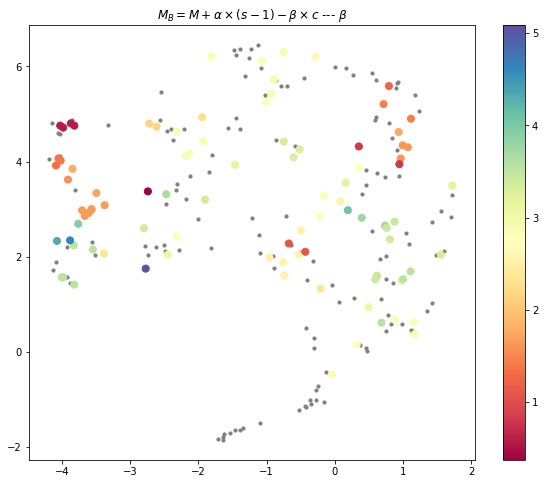

<Figure size 432x288 with 0 Axes>

In [355]:
#%matplotlib notebook
%matplotlib inline

#plt the map in result
plt.figure(figsize=(10,8))
umapmap = numpy.load('umap_frf.npy')
click_map = umapmap.copy()
plt.title(r'$M_{B} = M + \alpha \times (s-1) - \beta \times c$ --- $\beta$') # the parameters of the map
x = umapmap[:, 0]
y = umapmap[:, 1]
plt.scatter(x, y, color = 'gray', s = 10)
plt.scatter(x, y, c = b, s = 50, cmap="Spectral")
plt.colorbar()
plt.show()

#current_ax = plt.gca()
xn, xx = current_ax.get_xlim(); #print(xn, xx)
yn, yx = current_ax.get_ylim(); #print(yn, yx)
toggle_selector.RS = RectangleSelector(current_ax, line_select_callback,
                                           drawtype='box', useblit=True,
                                           button=[1, 3],  # don't use middle button
                                           minspanx=5, minspany=5,
                                           spancoords='pixels',
                                           interactive=True)
event = plt.connect('key_press_event', toggle_selector)

In [74]:
#beta1 = click_inds.copy()
#beta4 = click_inds.copy()

In [567]:
#charectaristics of all sample
print('median beta: ', numpy.median(beta[numpy.isfinite(beta)]))
print('median alpha: ', numpy.median(alpha[numpy.isfinite(alpha)]))
print('median M: ', numpy.median(m0[numpy.isfinite(m0)]))

median beta:  2.7758667989509656
median alpha:  0.8355725635474186
median M:  -19.362054925361978


### The acceptable alpha for this fitter is 1.34+-0.08 and beta is typicaly 2.59 +- 0.08

# Old alpha groups found by salt2 fitters

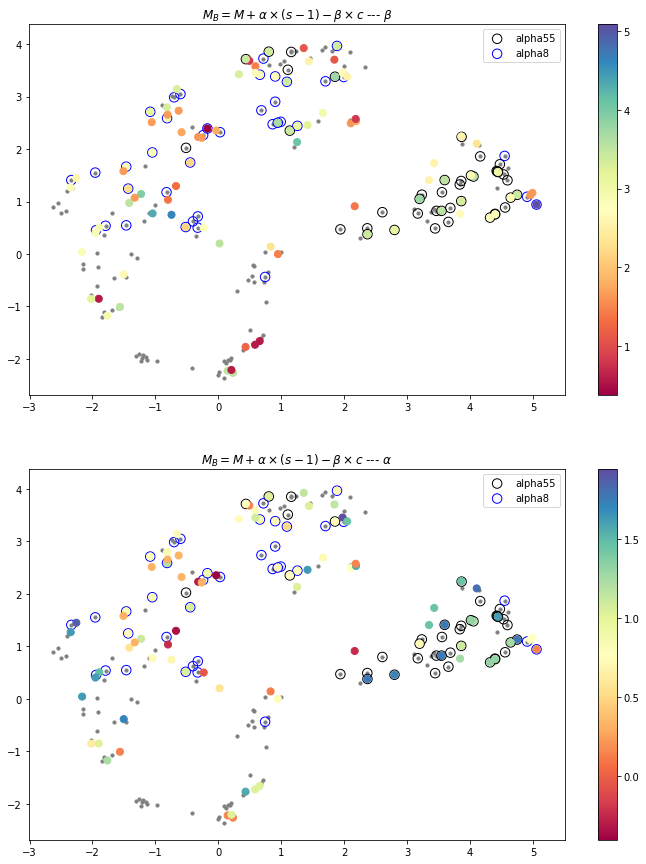

In [925]:
# for sulphur map

#plot the groups we get by the other fitter
alpha55 = numpy.load('alpha55.npy')
alpha8 = numpy.load('alpha8.npy')

# a - the width free parameter
a = alpha.copy()
a=numpy.array(a)

# a - the color free parameter
b =  beta.copy()
b=numpy.array(b)

#%matplotlib notebook
%matplotlib inline

plt.figure(figsize=(12,15))

plt.subplot(211)
umapmap = numpy.load('SII_5500_5320_umap.npy')
plt.title(r'$M_{B} = M + \alpha \times (s-1) - \beta \times c$ --- $\beta$')
x = umapmap[:, 0]
y = umapmap[:, 1]
plt.scatter(x, y, color = 'gray', s = 10)
plt.scatter(x[alpha55], y[alpha55], s=90, facecolors='none', edgecolors='black', label='alpha55')
plt.scatter(x[alpha8], y[alpha8], s=90, facecolors='none', edgecolors='blue', label='alpha8')
plt.scatter(x, y, c = b, s = 50, cmap="Spectral")
plt.colorbar()
plt.legend()

plt.subplot(212)
plt.title(r'$M_{B} = M + \alpha \times (s-1) - \beta \times c$ --- $\alpha$')
plt.scatter(x, y, color = 'gray', s = 10)
plt.scatter(x[alpha55], y[alpha55], s=90, facecolors='none', edgecolors='black', label='alpha55')
plt.scatter(x[alpha8], y[alpha8], s=90, facecolors='none', edgecolors='blue', label='alpha8')
plt.scatter(x, y, c = a, s = 50, cmap="Spectral")
plt.colorbar()
plt.legend()

plt.show()

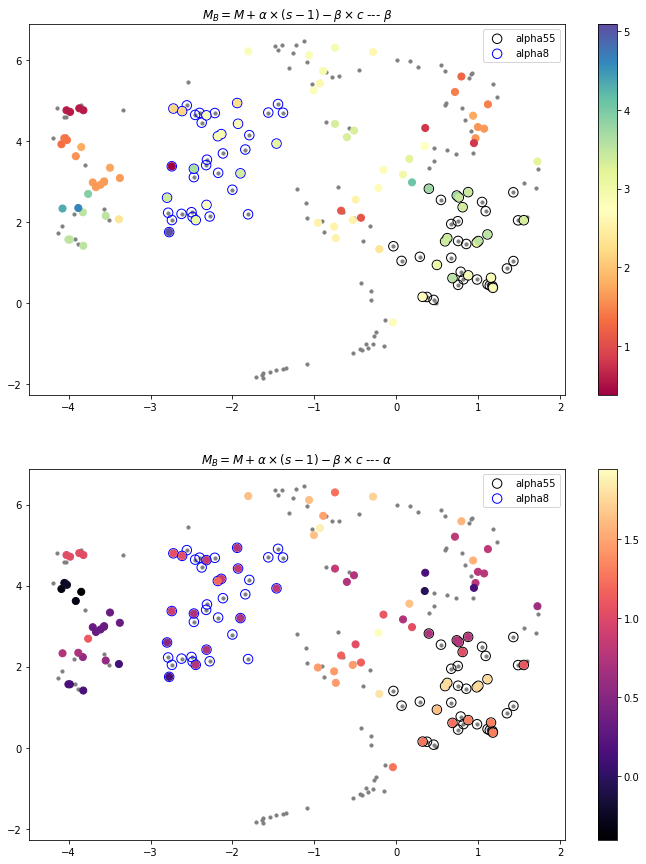

In [926]:
#plot the groups we get by the other fitter
alpha55 = numpy.load('alpha55.npy')
alpha8 = numpy.load('alpha8.npy')

#%matplotlib notebook
%matplotlib inline

plt.figure(figsize=(12,15))

plt.subplot(211)
umapmap = numpy.load('umap_frf.npy')
plt.title(r'$M_{B} = M + \alpha \times (s-1) - \beta \times c$ --- $\beta$')
x = umapmap[:, 0]
y = umapmap[:, 1]
plt.scatter(x, y, color = 'gray', s = 10)
plt.scatter(x[alpha55], y[alpha55], s=90, facecolors='none', edgecolors='black', label='alpha55')
plt.scatter(x[alpha8], y[alpha8], s=90, facecolors='none', edgecolors='blue', label='alpha8')
plt.scatter(x, y, c = b, s = 50, cmap="Spectral")
plt.colorbar()
plt.legend()

plt.subplot(212)
plt.title(r'$M_{B} = M + \alpha \times (s-1) - \beta \times c$ --- $\alpha$')
plt.scatter(x, y, color = 'gray', s = 10)
plt.scatter(x[alpha55], y[alpha55], s=90, facecolors='none', edgecolors='black', label='alpha55')
plt.scatter(x[alpha8], y[alpha8], s=90, facecolors='none', edgecolors='blue', label='alpha8')
plt.scatter(x, y, c = a, s = 50, cmap="magma")
plt.colorbar()
plt.legend()

plt.show()

In [563]:
# group characteristics
sn_alpha8 = SN_df_w_salt_w_class.loc[alpha8]

#checking which are in normal group:
idx = sn_alpha8[sn_alpha8['WClass_spec'].notnull()]['WClass_spec'].index
sn = sn_alpha8.loc[idx]
HV = sn[sn['WClass_spec'].str.contains('HV')]
N = sn[sn['WClass_spec'].str.contains('N')]

#prints
print('the bumber of SNe alpha8:' , len(alpha8))
print('the bumber of SNe in normal (N and HV) alpha8:' , ((HV['WClass_spec'].count())+(N['WClass_spec'].count())))
print('the median alpha8:' , numpy.median(alpha[alpha8][[numpy.isfinite(alpha[alpha8])]]))

the bumber of SNe alpha8: 38
the bumber of SNe in normal (N and HV) alpha8: 33
the median alpha8: 0.8064382359576391


In [564]:
# group characteristics
sn_alpha55 = SN_df_w_salt_w_class.loc[alpha55]

#checking which are in normal group:
idx = sn_alpha55[sn_alpha55['WClass_spec'].notnull()]['WClass_spec'].index
sn = sn_alpha55.loc[idx]
HV = sn[sn['WClass_spec'].str.contains('HV')]
N = sn[sn['WClass_spec'].str.contains('N')]

#prints
print('the bumber of SNe alpha55:' , len(alpha55))
print('the bumber of SNe in normal (N and HV) alpha55:' , ((HV['WClass_spec'].count())+(N['WClass_spec'].count())))
print('the median alpha55:' , numpy.median(alpha[alpha55][[numpy.isfinite(alpha[alpha55])]]))

the bumber of SNe alpha55: 41
the bumber of SNe in normal (N and HV) alpha55: 37
the median alpha55: 1.3172819961421456


In [566]:
#charectaristics of all sample
print('median beta: ', numpy.median(beta[numpy.isfinite(beta)]))
print('median alpha: ', numpy.median(alpha[numpy.isfinite(alpha)]))
print('median M: ', numpy.median(m0[numpy.isfinite(m0)]))

median beta:  2.7758667989509656
median alpha:  0.8355725635474186
median M:  -19.362054925361978


In [579]:
SN_df_w_salt_w_class.columns

Index(['idx', 'SN', 'zhel_spec', 'tmax(B)_spec', 'tmax(B)_err_spec',
       'ref_spec', 'Dm15_spec', 'Dm15_err_spec', 'ref1_spec', 'M_B_spec',
       'M_B_err_spec', 'B-V_spec', 'B-V_err_spec', 'Bm-Vm_spec',
       'Bm-Vm_err_spec', 'Phot_ref_spec', 'ref..2', 'n_spec', 'RA', 'DEC',
       'z_CMB', 'z_CMB_salt2_err', 'm_B_salt2', 'm_B_salt2_err', 'x_1_salt2',
       'x_1_salt2_err', 'c_salt2', 'c_salt2_err', 'mu_salt2', 'mu_salt2_err',
       'EW5972_spec', 'EW6355_spec', 'v6355_spec', 'Phase_spec', 'BClass_spec',
       'WClass_spec', 'SNIa_salt', 'z_cmb_salt', 'z_err_salt', 'm_B_salt',
       'm_B_err_salt', 's_salt', 's_err_salt', 'c_salt', 'c_err_salt',
       'mu_salt', 'mu_err_salt'],
      dtype='object')

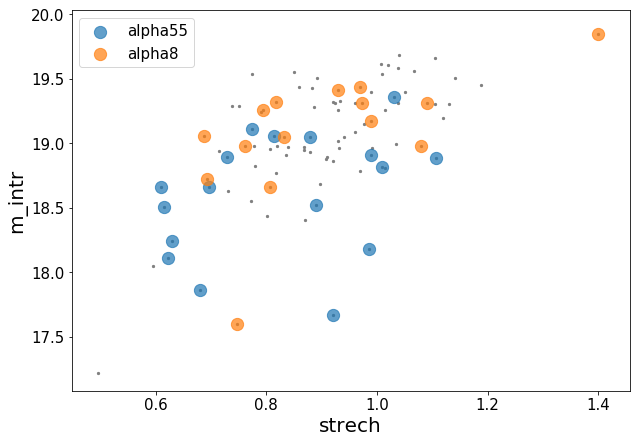

In [725]:

plt.figure(figsize=(10,7))
Y_all = z_CMB_distmod.value - SN_df_w_salt_w_class['m_B_salt'].values.copy()
X_all =  SN_df_w_salt_w_class['s_salt'].values.copy()
#Y_all[Y_all<-30] = numpy.nan

#x_grid = numpy.arange(numpy.nanmin(X_all), numpy.nanmax(X_all[X_all < 1.7]), 0.001)

plt.scatter(X_all, Y_all, c='gray', s = 5)


#plt.scatter(X_all[g4], Y_all[g4], )
#plt.gca().set_prop_cycle(None)
x_ = X_all[alpha55].copy()
y_ = Y_all[alpha55].copy()
has_vals = numpy.where(numpy.isfinite(alpha[alpha55]))[0]
x_ = x_[has_vals]
y_ = y_[has_vals]
plt.scatter(x_, y_, s=150, alpha = 0.7, label='alpha55')

x_ = X_all[alpha8].copy()
y_ = Y_all[alpha8].copy()
has_vals = numpy.where(numpy.isfinite(alpha[alpha8]))[0]
x_ = x_[has_vals]
y_ = y_[has_vals]
plt.scatter(x_, y_, s=150, alpha = 0.7, label='alpha8')


plt.legend(fontsize =15)
plt.xlabel('strech', fontsize = 20)
plt.ylabel('m_intr', fontsize = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


plt.show()

# Hubble Diagram- salt parameters

<font color=red>
## !!!!!!!! need to fix the y error from mu_err_salt to the z_cmb_dist from cosmolgy error

<img src="dis.jpeg">

In [908]:
# fitting the linear fit for the choosen groups
has_m_b = numpy.where((numpy.isfinite(SN_df_w_salt_w_class['s_salt'].values)))[0]

Y = z_CMB_distmod.value - SN_df_w_salt_w_class['m_B_salt'].values.copy()
X = numpy.vstack([SN_df_w_salt_w_class['s_salt'].values, SN_df_w_salt_w_class['c_salt'].values]).T

dY = numpy.sqrt(SN_df_w_salt_w_class['mu_err_salt'].values.copy()**2 + SN_df_w_salt_w_class['m_B_err_salt'].values.copy()**2)
dX = numpy.vstack([SN_df_w_salt_w_class['s_err_salt'].values, SN_df_w_salt_w_class['c_err_salt'].values]).T

# fit for all sample together

g = has_m_b #alpha without nans

x_ = X[g].copy()
dx_ = dX[g].copy()
y_ = Y[g].copy()
dy_ = dY[g].copy()
inter, a, b  = lin_fit(x_, dx_, y_, dy_)

alpha_all_fit = a
beta_all_fit = b
m0_all_fit = inter
x_all_fit = X[g].copy()

# fit for alpha55

g = numpy.intersect1d(alpha55, has_m_b) #alpha55 without nans

x_ = X[g].copy()
dx_ = dX[g].copy()
y_ = Y[g].copy()
dy_ = dY[g].copy()
inter, a, b  = lin_fit(x_, dx_, y_, dy_)

alpha55_fit = a
beta55_fit = b
m055_fit = inter
x55 = X[alpha55].copy()

# for alpha8
g =  numpy.intersect1d(alpha8, has_m_b)

x_ = X[g].copy()
dx_ = dX[g].copy()
y_ = Y[g].copy()
dy_ = dY[g].copy()
inter, a, b  = lin_fit(x_, dx_, y_, dy_)

alpha8_fit = a
beta8_fit = b
m08_fit = inter
x8 = X[alpha8].copy()


In [909]:
#check statistics

print('parameters when calculated for entire group:')
print('all: a= %.2f, b= %.2f, mo= %.2f' % (alpha_all_fit, beta_all_fit, m0_all_fit))
print('alpha55: a= %.2f, b= %.2f, mo= %.2f' % (alpha55_fit, beta55_fit, m055_fit))
print('alpha8: a= %.2f, b= %.2f, mo= %.2f' % (alpha8_fit, beta8_fit, m08_fit))

# group characteristics
print('median parameters of the group when calculated for each SN with 8 nn:')
print('alpha55: med_a: %.2f, med_b: %.2f, med_m0: %.2f' % (numpy.median(alpha[alpha55][[numpy.isfinite(alpha[alpha55])]]), numpy.median(beta[alpha55][[numpy.isfinite(beta[alpha55])]]), 
numpy.median(m0[alpha55][[numpy.isfinite(m0[alpha55])]])))
print('alpha8: med_a: %.2f, med_b: %.2f, med_m0: %.2f' % (numpy.median(alpha[alpha8][[numpy.isfinite(alpha[alpha8])]]), numpy.median(beta[alpha8][[numpy.isfinite(beta[alpha8])]]), 
numpy.median(m0[alpha8][[numpy.isfinite(m0[alpha8])]])))


parameters when calculated for entire group:
all: a= 1.04, b= 2.89, mo= -19.34
alpha55: a= 1.12, b= 3.34, mo= -19.31
alpha8: a= 0.98, b= 2.94, mo= -19.30
median parameters of the group when calculated for each SN with 8 nn:
alpha55: med_a: 1.32, med_b: 3.43, med_m0: -19.34
alpha8: med_a: 0.81, med_b: 2.87, med_m0: -19.31


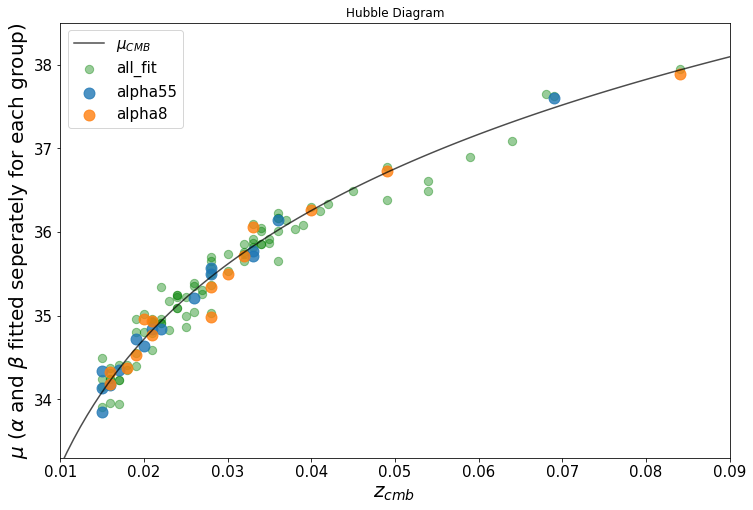

In [923]:
# Hubble diagram for the groups alpha and betha using the entire group for the fit
plt.figure(figsize=(12,8))

#for all sample with fitting parameters from paper

if False: 
    m0_paper=-19.46
    a_paper=1.34
    b_paper=2.59

    d_all =  SN_df_w_salt_w_class['m_B_salt'].values.copy() + model(m0_paper, a_paper, b_paper, X.copy())
    z_all = SN_df_w_salt_w_class['z_CMB'].copy()
    plt.scatter(z_all, d_all, s=30, alpha = 0.6, color='gray', label='all (paper_param)')

#for all sample fit in one group

d_all_fit =  SN_df_w_salt_w_class['m_B_salt'].values[has_m_b].copy() + model(m0_all_fit, alpha_all_fit, beta_all_fit, x_all_fit)
z_all = SN_df_w_salt_w_class['z_CMB'].copy()
z_all_fit = z_all[has_m_b].copy()
plt.scatter(z_all_fit, d_all_fit, s=70, alpha = 0.4, color='green', label='all_fit')

#for alpha55 only

d_55 = SN_df_w_salt_w_class['m_B_salt'].values[alpha55].copy() + model(m055_fit, alpha55_fit, beta55_fit, x55)
z_all = SN_df_w_salt_w_class['z_CMB']
z_55 = z_all[alpha55].copy()
plt.scatter(z_55, d_55, s=120, alpha = 0.8, label='alpha55')

#for alpha8 only

d_8 =  SN_df_w_salt_w_class['m_B_salt'].values[alpha8].copy() + model(m08_fit, alpha8_fit, beta8_fit, x8)
z_all = SN_df_w_salt_w_class['z_CMB']
z_8 = z_all[alpha8].copy()
#d_ = dis_all[alpha8].copy()
plt.scatter(z_8, d_8, s=120, alpha = 0.8, label='alpha8')

#for perfect fit from cosmological model
z_grid = numpy.linspace(0.01, 0.09, 100)
z_grid_distmod = cosmo.distmod(z_grid)
plt.plot(z_grid, z_grid_distmod,  alpha = 0.7, label=(r'$\mu_{CMB}$'), color='black')

plt.legend(fontsize =15)
plt.xlabel(r'$z_{cmb}$ ', fontsize = 20)
plt.ylabel(r'$\mu$ ($\alpha$ and $\beta$ fitted seperately for each group)', fontsize = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Hubble Diagram')
plt.ylim(33.3,38.5)
plt.xlim(0.01,0.09)


plt.show()

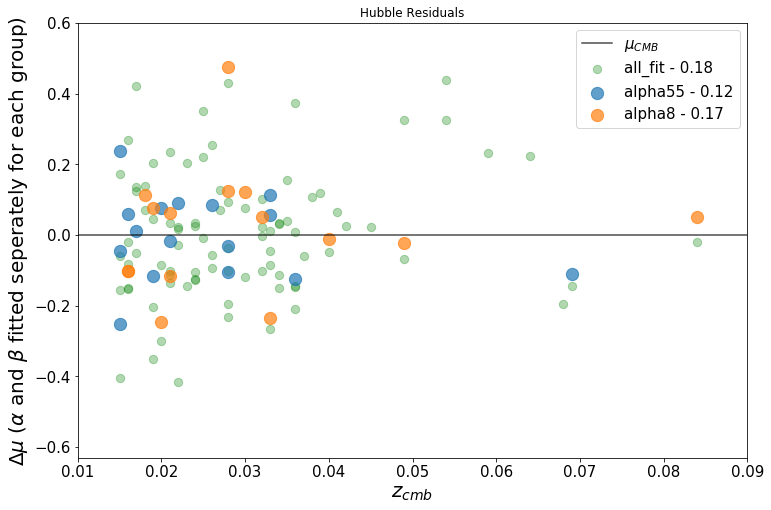

In [924]:
# Hubble diagram for the groups alpha and betha using the entire group for the fit - SALT
plt.figure(figsize=(12,8))

#for all sample with fitting parameters from paper
if False:   ##################### way to do notes
    m0_paper=-19.46
    a_paper=1.34
    b_paper=2.59

    d_all =  SN_df_w_salt_w_class['m_B_salt'].values.copy() + model(m0_paper, a_paper, b_paper, X.copy())
    z_all = SN_df_w_salt_w_class['z_CMB'].copy()
    plt.scatter(z_all, (z_CMB_distmod.value - d_all), s=20, alpha = 0.7, color='gray', label='all (paper_param)')

#for all sample fit in one group

d_all_fit =  SN_df_w_salt_w_class['m_B_salt'].values[has_m_b].copy() + model(m0_all_fit, alpha_all_fit, beta_all_fit, x_all_fit)
z_all = SN_df_w_salt_w_class['z_CMB'].copy()
z_all_fit = z_all[has_m_b].copy()
y = (z_CMB_distmod.value[has_m_b] - d_all_fit)
std = numpy.nanstd(y)
plt.scatter(z_all_fit, y, s=70, alpha = 0.3, color='green', label='all_fit - {:.2f}'.format(std))

#for alpha55 only

d_55 = SN_df_w_salt_w_class['m_B_salt'].values[alpha55].copy() + model(m055_fit, alpha55_fit, beta55_fit, x55)
z_all = SN_df_w_salt_w_class['z_CMB']
z_55 = z_all[alpha55].copy()
y = (z_CMB_distmod.value[alpha55] - d_55)
std = numpy.nanstd(y)
plt.scatter(z_55, y, s=150, alpha = 0.7, label='alpha55 - {:.2f}'.format(std))

#for alpha8 only

d_8 =  SN_df_w_salt_w_class['m_B_salt'].values[alpha8].copy() + model(m08_fit, alpha8_fit, beta8_fit, x8)
z_all = SN_df_w_salt_w_class['z_CMB']
z_8 = z_all[alpha8].copy()
y = (z_CMB_distmod.value[alpha8] - d_8)
std = numpy.nanstd(y)
plt.scatter(z_8, y, s=150, alpha = 0.7, label='alpha8 - {:.2f}'.format(std))

#for perfect fit from cosmological model
z_grid = numpy.linspace(0.01, 0.09, 100)
z_grid_distmod = cosmo.distmod(z_grid)
plt.plot(z_grid, z_grid_distmod-z_grid_distmod,  alpha = 0.7, label=(r'$\mu_{CMB}$'), color='black')

plt.legend(fontsize =15)
plt.xlabel(r'$z_{cmb}$ ', fontsize = 20)
plt.ylabel(r'$\Delta\mu$ ($\alpha$ and $\beta$ fitted seperately for each group)', fontsize = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Hubble Residuals')
plt.ylim(-0.63,0.6)
plt.xlim(0.01,0.09)

plt.show()

### The acceptable alpha for this fitter is 1.34+-0.08

In [484]:
# Trying to fit Riess's ---> non in our group
riess=['1995ao', '1995ap', '1996e', '1996h', '1996i', '1996j', '1996k', '1996r', '1996t', '1996u', '1997ce', '1997cj', '1997ck']

for r in riess:
    if r in SN_df_w_salt_w_class['SN'].values:
        print(SN_df_w_salt_w_class[SN_df_w_salt_w_class['SN'] == r].index[0])
    #print((SN_df_w_salt_w_class['SN'].where(SN_df_w_salt_w_class['SN'] == riess[i])).notnull().index[0])   


# New Beta Groups

### Beta is typicaly 2.59 +- 0.08

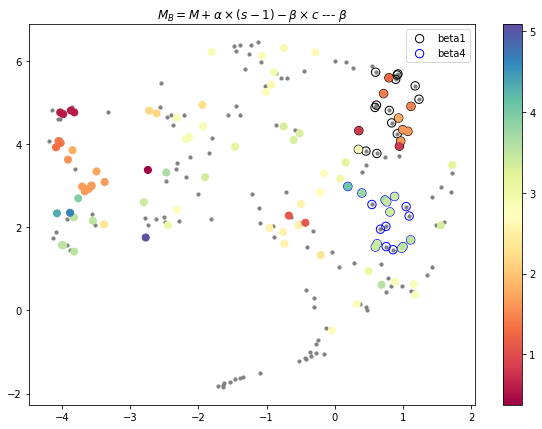

In [328]:
# plot the choosem groups

#%matplotlib notebook
%matplotlib inline

plt.figure(figsize=(10,7))
umapmap = numpy.load('umap_frf.npy')
plt.title(r'$M_{B} = M + \alpha \times (s-1) - \beta \times c$ --- $\beta$')
x = umapmap[:, 0]
y = umapmap[:, 1]
plt.scatter(x, y, color = 'gray', s = 10)
plt.scatter(x[beta1], y[beta1], s=70, facecolors='none', edgecolors='black', label='beta1')
plt.scatter(x[beta4], y[beta4], s=70, facecolors='none', edgecolors='blue', label='beta4')
plt.scatter(x, y, c = b, s = 50, cmap="Spectral")
plt.colorbar()
plt.legend()
plt.show()


In [110]:
beta1

array([  1,   3,   8,  11,  16,  64,  69,  73,  75,  80,  83, 128, 132,
       160, 161, 165, 166, 174, 206, 208, 215, 216, 226])

In [101]:
# df only with this group
sn_beta1 = SN_df_w_salt_w_class.loc[beta1]

In [330]:
# group characteristics

#checking which are in normal group:
HV = sn_beta1[sn_beta1['WClass_spec'].str.contains('HV')]
N = sn_beta1[sn_beta1['WClass_spec'].str.contains('N')]
noraml=((HV['WClass_spec'].count())+(N['WClass_spec'].count()))

#prints
print('the bumber of SNe Beta1:' , len(beta1))
print('the bumber of SNe in normal (N and HV) Beta1:' , ((HV['WClass_spec'].count())+(N['WClass_spec'].count())))
print('the median beta1:' , numpy.median(beta[beta1][[numpy.isfinite(beta[beta1])]]))

the bumber of SNe Beta1: 23
the bumber of SNe in normal (N and HV) Beta1: 23
the median beta1: 1.5299267448672238


In [331]:
beta4

array([  9,  23,  32,  49,  57,  68,  79,  95, 123, 127, 158, 162, 179,
       181, 188, 205, 218, 220])

In [332]:
# df only with this group
sn_beta4 = SN_df_w_salt_w_class.loc[beta4]

In [333]:
# group characteristics

#checking which are in normal group:
HV = sn_beta4[sn_beta4['WClass_spec'].str.contains('HV')]
N = sn_beta4[sn_beta4['WClass_spec'].str.contains('N')]
noraml=((HV['WClass_spec'].count())+(N['WClass_spec'].count()))

#prints
print('the bumber of SNe beta4:' , len(beta4))
print('the bumber of SNe in normal (N and HV) beta4:' , ((HV['WClass_spec'].count())+(N['WClass_spec'].count())))
print('the median beta4:' , numpy.median(beta[beta4][[numpy.isfinite(beta[beta4])]]))

the bumber of SNe beta4: 18
the bumber of SNe in normal (N and HV) beta4: 18
the median beta4: 3.445860848257401


## Beta1

<IPython.core.display.Javascript object>


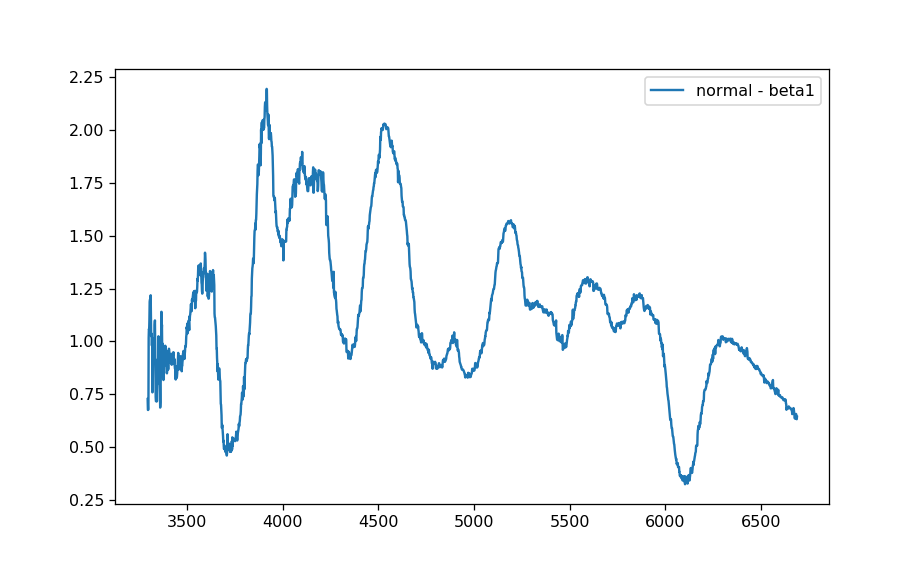

In [79]:
# median spectra

plt.figure(figsize = (8,5))
x_plt = numpy.median(X_SG[beta1], axis = 0) # blue
#y_plt = numpy.median(X_SG[broad], axis = 0) # orange
#z_plt = numpy.median(X_SG[Iax_indx], axis = 0) # green 
plt.plot(CW, x_plt, label='normal - beta1')
#plt.plot(cw, y_plt+1, label='broad/hv')
#plt.plot(cw, z_plt+2, label='Iax')
#y_plt = numpy.median(X_SG[red1], axis = 0)
#plt.plot(x_plt)
plt.legend()
plt.show()

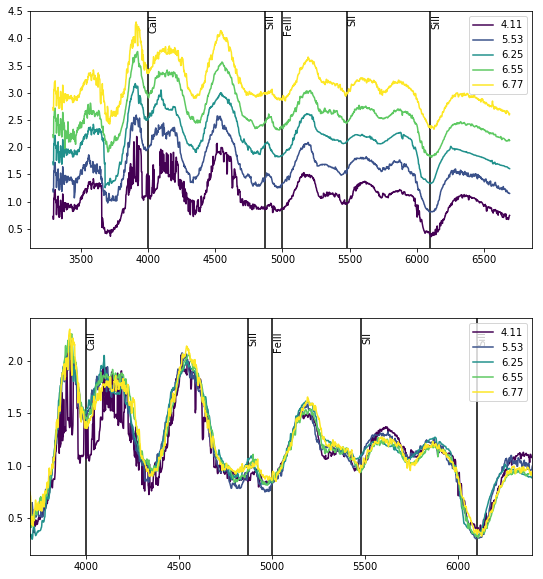

[4.11  5.534 6.252 6.545 6.775]


In [240]:
# change by time

reload(specplotlib)

t = numpy.load('sn_spec_time.npy') 
group = beta1.copy()
n_groups = 5
sorted_indx=group[numpy.argsort(t[group])]

groups = numpy.array_split(sorted_indx, n_groups)

line_list = [4000,4870,6100,5000,5480]
name_list = ['CaII','SiII','SiII','FeIII','SII']
gap = 0.5

plot_group (groups, gap, line_list, name_list, t)

t_min=2.97 ---> t_max=6.82
median t = 6.17


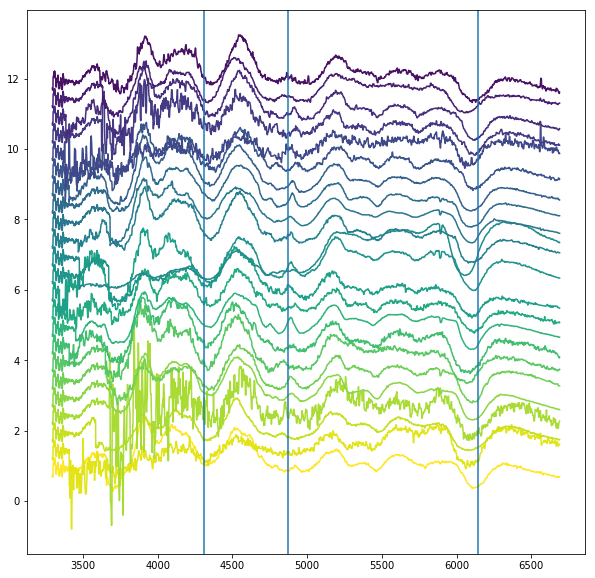

In [243]:
reload(specplotlib)
group = beta1.copy()
t = numpy.load('sn_spec_time.npy') 
time = t[group]

print("t_min=%.2f ---> t_max=%.2f" % (min(time),max(time)))
print("median t = %.2f" % (numpy.median(time)))
temp = specplotlib.ladder_plot_smooth(CW, X_SG, group, t, len(group), 0.5) 

# the file with wavwlength bins, the spectra metrix, the indx of the spectras to display, 
# the order parameter, how many spectra t show (can stack), the spacing)

## Beta4

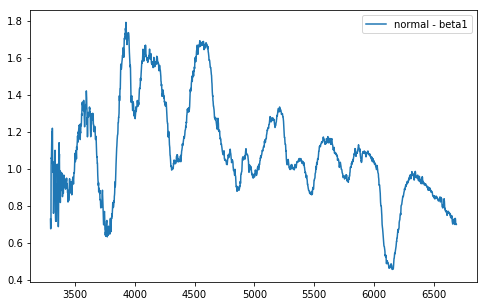

In [258]:
# median spectra

plt.figure(figsize = (8,5))
x_plt = numpy.median(X_SG[beta4], axis = 0) # blue
#y_plt = numpy.median(X_SG[broad], axis = 0) # orange
#z_plt = numpy.median(X_SG[Iax_indx], axis = 0) # green 
plt.plot(CW, x_plt, label='normal - beta1')
#plt.plot(cw, y_plt+1, label='broad/hv')
#plt.plot(cw, z_plt+2, label='Iax')
#y_plt = numpy.median(X_SG[red1], axis = 0)
#plt.plot(x_plt)
plt.legend()
plt.show()

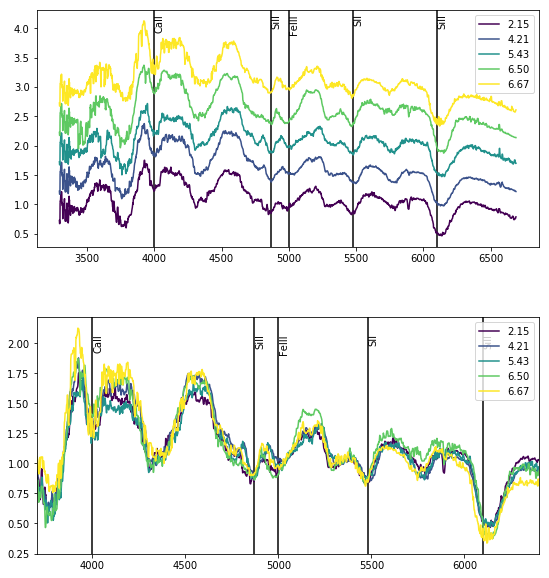

[2.1475     4.2125     5.43       6.5        6.66666667]


In [259]:
# change by time

reload(specplotlib)

t = numpy.load('sn_spec_time.npy') 
group = beta4.copy()
n_groups = 5
sorted_indx=group[numpy.argsort(t[group])]

groups = numpy.array_split(sorted_indx, n_groups)

line_list = [4000,4870,6100,5000,5480]
name_list = ['CaII','SiII','SiII','FeIII','SII']
gap = 0.5

plot_group (groups, gap, line_list, name_list, t)

## Comparison

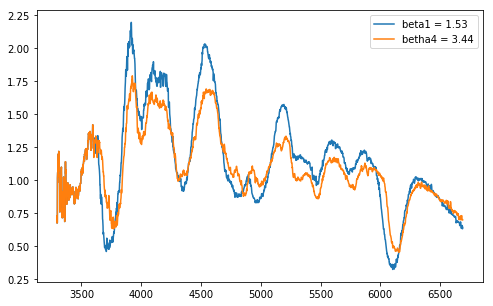

In [263]:
plt.figure(figsize = (8,5))
x_plt = numpy.median(X_SG[beta1], axis = 0) # blue
y_plt = numpy.median(X_SG[beta4], axis = 0) # orange
plt.plot(CW, x_plt, label='beta1 = 1.53')
plt.plot(CW, y_plt, label='betha4 = 3.44')
#plt.plot(cw, y_plt+1, label='betha90')
plt.legend()
plt.show()

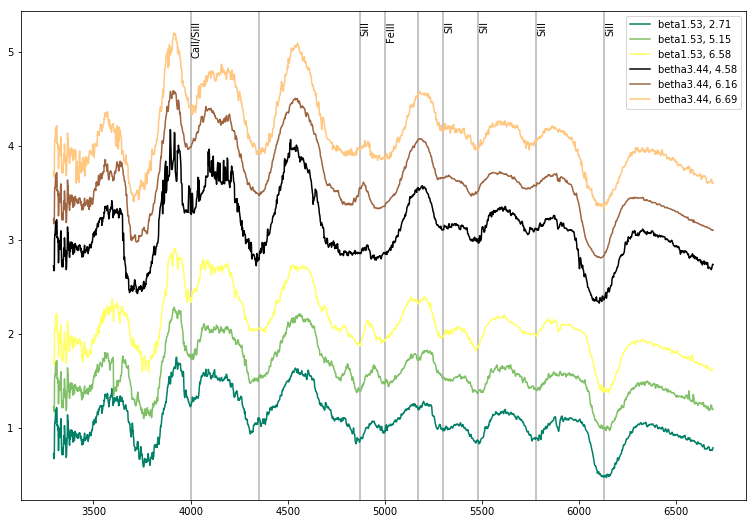

In [273]:
reload(specplotlib)

t = numpy.load('sn_spec_time.npy') 

group = beta1.copy()
n_groups = 3
sorted_indx=group[numpy.argsort(t[group])]
groups90 = numpy.array_split(sorted_indx, n_groups)
groups90_t = numpy.array([numpy.mean(t[g]) for g in groups90]) #creating the list in 1 line 

group = beta4.copy()
n_groups = 3
sorted_indx=group[numpy.argsort(t[group])]
groups55 = numpy.array_split(sorted_indx, n_groups)
groups55_t = numpy.array([numpy.mean(t[g]) for g in groups55]) #creating the list in 1 line 

groups = [groups55, groups90]
line_list = [4000,4870,6130,5000,5780,4350,5170,5480,5300]
name_list = ['CaII/SiII','SiII','SiII','FeIII','SiII','','','SII','SII']
gap = 0.5

plt.figure(figsize = (13,9))
cmap = get_cmap('summer')
for n in range (0,len(groups55)):
    c = n/(len(groups55)-1)
    x_plt = numpy.median(X_SG[groups55[n]], axis = 0) # blue
    plt.plot(CW, x_plt+gap*n, label='beta1.53, %.2f' % groups55_t[n], color=cmap(c))
cmap = get_cmap('copper')
for m in range (0,len(groups90)):
    c = m/(len(groups90)-1)
    y_plt = numpy.median(X_SG[groups90[m]], axis = 0) # orange
    plt.plot(CW, y_plt+gap*(n+m+2), label='betha3.44, %.2f' % groups90_t[m], color=cmap(c))
    #plt.plot(cw, y_plt+1, label='betha90')
plt.legend()

ax = plt.gca() # holds all the data of the image
ylim = ax.get_ylim() # keeps the ylim for the upper and border limits of the line
plt.vlines(x=[line_list], ymin=ylim[0], ymax=ylim[1], alpha=0.3)
for n in range (0,len(line_list)):
    plt.text(x=(line_list[n]+4), y=ylim[1]-0.2, s=name_list[n], rotation=90)
plt.ylim(ylim)
plt.ylim(ylim)
#plt.xlim([3500,4000])
plt.legend()
plt.show()

#plot_group (groups55, gap, line_list, name_list, t)


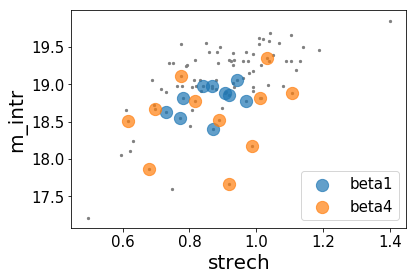

In [568]:
plt.figure(figsize=(6,4))
Y_all = z_CMB_distmod.value - SN_df_w_salt_w_class['m_B_salt'].values.copy()
X_all =  SN_df_w_salt_w_class['s_salt'].values.copy()
#Y_all[Y_all<-30] = numpy.nan

#x_grid = numpy.arange(numpy.nanmin(X_all), numpy.nanmax(X_all[X_all < 1.7]), 0.001)

plt.scatter(X_all, Y_all, c='gray', s = 5)

#plt.scatter(X_all[g4], Y_all[g4], )
#plt.gca().set_prop_cycle(None)
x_ = X_all[beta1].copy()
y_ = Y_all[beta1].copy()
has_vals = numpy.where(numpy.isfinite(beta[beta1]))[0]
x_ = x_[has_vals]
y_ = y_[has_vals]
plt.scatter(x_, y_, s=150, alpha = 0.7, label='beta1')



x_ = X_all[beta4].copy()
y_ = Y_all[beta4].copy()
has_vals = numpy.where(numpy.isfinite(beta[beta4]))[0]
x_ = x_[has_vals]
y_ = y_[has_vals]
plt.scatter(x_, y_, s=150, alpha = 0.7, label='beta4')

plt.legend(fontsize =15)
plt.xlabel('strech', fontsize = 20)
plt.ylabel('m_intr', fontsize = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


plt.show()

No handles with labels found to put in legend.


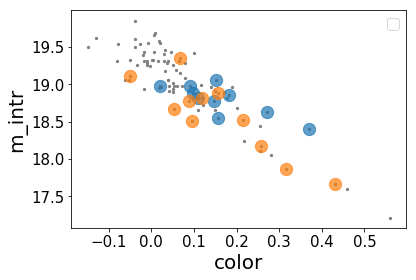

In [283]:
plt.figure(figsize=(6,4))
Y_all = z_CMB_distmod.value - SN_df_w_salt_w_class['m_B_salt'].values.copy()
X_all =  SN_df_w_salt_w_class['c_salt'].values.copy()
#Y_all[Y_all<-30] = numpy.nan

#x_grid = numpy.arange(numpy.nanmin(X_all), numpy.nanmax(X_all[X_all < 1.7]), 0.001)

plt.scatter(X_all, Y_all, c='gray', s = 5)

#plt.scatter(X_all[g4], Y_all[g4], )
#plt.gca().set_prop_cycle(None)
x_ = X_all[beta1].copy()
y_ = Y_all[beta1].copy()
has_vals = numpy.where(numpy.isfinite(beta[beta1]))[0]
x_ = x_[has_vals]
y_ = y_[has_vals]
plt.scatter(x_, y_, s=150, alpha = 0.7)



x_ = X_all[beta4].copy()
y_ = Y_all[beta4].copy()
has_vals = numpy.where(numpy.isfinite(beta[beta4]))[0]
x_ = x_[has_vals]
y_ = y_[has_vals]
plt.scatter(x_, y_, s=150, alpha = 0.7)

plt.legend(fontsize =15)
plt.xlabel('color', fontsize = 20)
plt.ylabel('m_intr', fontsize = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

# Template

In [22]:
from importlib import reload
reload(specplotlib)

<module 'specplotlib' from '/Users/natalie/git/SNIa/specplotlib.py'>

In [ ]:
# Choose an area to do the fits
plt.figure(figsize = (15,7))
plt.plot(CW, X_SG[0])
s = 1450
e = 1770
X = X_SG[:,s:e].copy()
wave = CW[s:e].copy()


plt.plot(wave, X[0])


plt.show()

In [ ]:
# normalize the spectra
#X_norm = X.copy()
X_norm = get_norm_X(X)

In [ ]:
# fit with umap distance calculation using default matrix (uclidiean)
specplotlib.umap_param_scan(X_norm)

In [ ]:
import umap

s_umap = umap.UMAP(n_neighbors=10,
                      min_dist=0.01).fit_transform(X_norm)

In [ ]:
specplotlib.embedding_plot_spec_meas(s_umap, SN_df_w_salt_w_class)

In [ ]:
specplotlib.embedding_plot_groups(s_umap, SN_df_w_salt_w_class)

In [ ]:
specplotlib.embedding_plot_salt_lc_params(s_umap, SN_df_w_salt_w_class, s=100)
# M is calculated from distance modulus calculated from z

In [ ]:
specplotlib.embedding_plot_salt_fit_params(s_umap, alpha, beta, m0, s = 50)

In [ ]:
specplotlib.embedding_plot_time_params(s_umap,  m0, s = 50)

In [87]:
numpy.save('Ti_?????_umap.npy' ,s_umap)

In [ ]:
# load map 
s_umap = numpy.load('SiII_4870_FeIII_5000_umap.npy')
x=s_umap[:,0]
y=s_umap[:,1]

# move to SN_data_frame notebook after pull

In [26]:
len(numpy.where((SN_df_w_salt_w_class['M_B_spec'].values)>-50)[0])

103

In [22]:
len(numpy.where((numpy.isfinite(SN_df_w_salt_w_class['x_1_salt2'].values)))[0])

114

In [21]:
len(numpy.where((numpy.isfinite(SN_df_w_salt_w_class['s_salt'].values)))[0])

92